In [101]:
import numpy as np
import sigmf
import scipy
import matplotlib.pyplot as plt
from py3gpp import *

In [102]:
# handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
# f = 1
# mu = 0
# apply_fine_CFO = 0
# delta_f = 0
# search_range = 2000

handle = sigmf.sigmffile.fromfile('772850KHz_3840KSPS_low_gain.sigmf-data') # N_id_2 = 0, N_id_1 = 291, N_id = 873
delta_f = -4e3
f = 772.85e6
mu = 0
apply_fine_CFO = 1
search_range = 5000

waveform = handle.read_samples()
waveform /= max(waveform.real.max(), waveform.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)
waveform = waveform * np.exp(-1j*(2*np.pi*delta_f/fs*np.arange(waveform.shape[0])))  

detected NID2 is 0
max correlation is 548523.41753566 at 2386


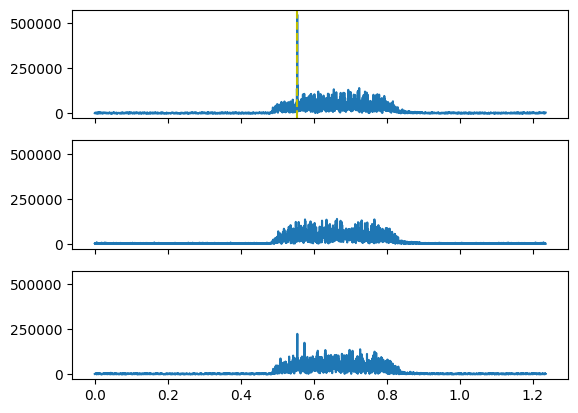

In [103]:
# optimized correlation with decimation, performed with integers

dec_factor = int(fs / 3840000)
FFT_LEN=256
if dec_factor > 1:
    waveform2 = scipy.signal.decimate(waveform, dec_factor, ftype='fir')
else:
    waveform2 = waveform
waveform2 /= max(waveform2.real.max(), waveform2.imag.max())
waveform2 *= 2**7
waveform2 = waveform2.real.astype(int) + 1j*waveform2.imag.astype(int)

peak_value = np.zeros(3)
peak_index = np.zeros(3, 'int')
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for current_NID2 in np.arange(3, dtype='int'):
    PSS = np.zeros(FFT_LEN, 'complex')
    PSS[64:64+127] = nrPSS(current_NID2)
    refWaveform = np.fft.ifft(np.fft.fftshift(PSS))
    refWaveform /= max(refWaveform.real.max(), refWaveform.imag.max())
    refWaveform *= 2**7
    refWaveform = refWaveform.real.astype(int) + 1j*refWaveform.imag.astype(int)
    temp = scipy.signal.correlate(waveform2[:search_range], refWaveform, 'valid')  # correlate over 1000 samples
    peak_index[current_NID2] = np.argmax(np.abs(temp))
    peak_value[current_NID2] = np.abs(temp[peak_index[current_NID2]])
    t_corr = np.arange(temp.shape[0])/(fs/dec_factor)*1e3
    axs[current_NID2].plot(t_corr, np.abs(temp))
detected_NID2 = np.argmax(peak_value)

axs[detected_NID2].axvline(x = t_corr[peak_index[detected_NID2]], color = 'y', linestyle = '--', label = 'axvline - full height')
print(f'detected NID2 is {detected_NID2}')
peak_pos = peak_index[detected_NID2] + FFT_LEN
print(f'max correlation is {peak_value[detected_NID2]} at {peak_pos}')
# np.abs(np.dot(refWaveform.conj(), waveform2[peak_index[detected_NID2] :][:128]))

start_pos for SSB1 is 2404
start_pos for SSB2 is 79204


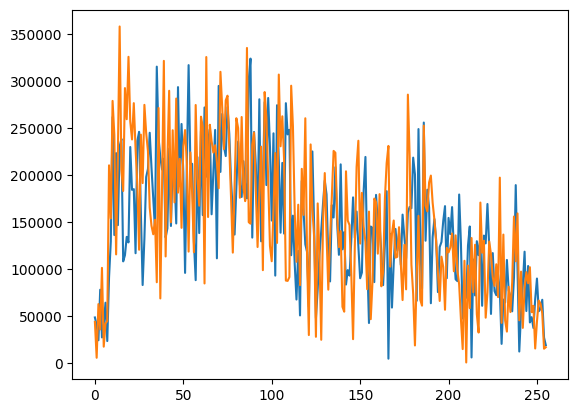

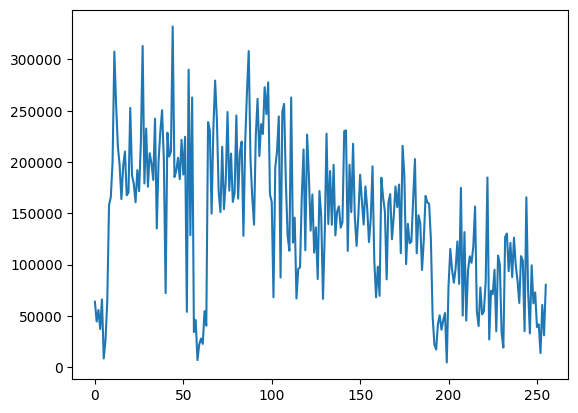

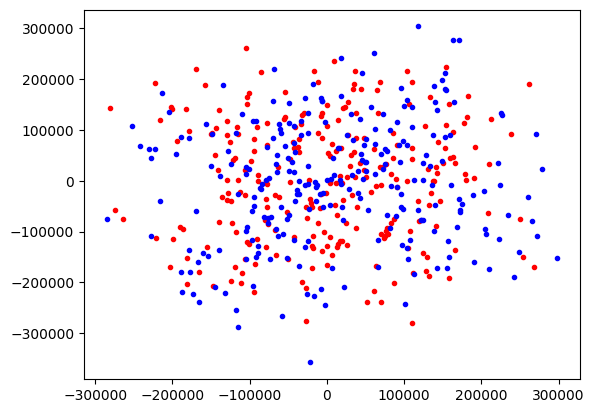

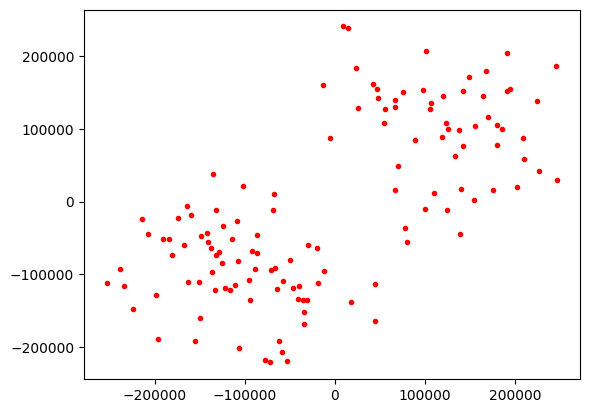

In [104]:
FFT_LEN = 256
cp1 = 18
if dec_factor > 1:
    waveform2 = scipy.signal.decimate(waveform, dec_factor, ftype='fir')
waveform2 /= max(waveform2.real.max(), waveform2.imag.max())
waveform2 *= ((2**15) - 1)
waveform2 = waveform2.real.astype(int) + 1j*waveform2.imag.astype(int)
start_pos = peak_pos + cp1
print(f'start_pos for SSB1 is {start_pos}')
SSB1 = waveform2[start_pos:][:FFT_LEN]
SSB1_fd = np.fft.fftshift(np.fft.fft(SSB1))
SSB1_symbol2 = waveform2[start_pos + FFT_LEN + cp1:][:FFT_LEN]
SSB1_symbol2_fd = np.fft.fftshift(np.fft.fft(SSB1_symbol2))

delta_t = 0.02
start_pos = start_pos + int(0.02 * fs / dec_factor)
print(f'start_pos for SSB2 is {start_pos}')
SSB2 = waveform2[start_pos:][:FFT_LEN]
SSB2_fd = np.fft.fftshift(np.fft.fft(SSB2))

plt.plot(np.abs(SSB1_fd))
plt.plot(np.abs(SSB2_fd))
plt.show()

plt.plot(np.abs(SSB1_symbol2_fd))
plt.show()

plt.plot(SSB1_fd.real, SSB1_fd.imag, 'r.')
plt.plot(SSB2_fd.real, SSB2_fd.imag, 'b.')
plt.show()

subcarriers_ss = slice(FFT_LEN//2 - 64, FFT_LEN//2 +63)
plt.plot(SSB1_symbol2_fd.real[subcarriers_ss], SSB1_symbol2_fd.imag[subcarriers_ss], 'r.')
plt.show()